In [4]:
%pip install fastf1

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 14.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from urllib.request import urlopen
import json
import pandas as pd

response = urlopen('https://api.openf1.org/v1/car_data?driver_number=55&session_key=9159&speed>=315')
data = json.loads(response.read().decode('utf-8'))

df = pd.DataFrame(data)
df

,driver_number,rpm,speed,n_gear,throttle,brake,drs,date,session_key,meeting_key
0,55,11141,315,8,99,0,12,2023-09-15T13:08:19.923000+00:00,9159,1219
1,55,11023,315,8,57,100,8,2023-09-15T13:35:41.808000+00:00,9159,1219


core           INFO 	Loading data for British Grand Prix - Race [v3.4.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

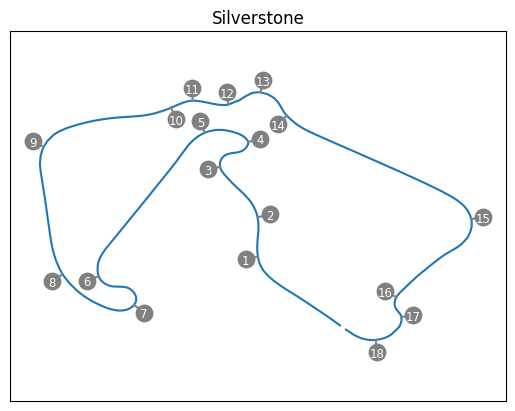

In [6]:
"""Draw a track map with numbered corners
=========================================

Use the position data of a single lap to draw a track map.
Then annotate the map with corner numbers.
"""
##############################################################################
# Import FastF1 and load the data. Use the telemetry from the fastest for the
# track map. (You could also use any other lap instead.)

import matplotlib.pyplot as plt
import numpy as np

import fastf1


session = fastf1.get_session(2024, 'Silverstone', 'R')
session.load()

lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

circuit_info = session.get_circuit_info()


##############################################################################
# Define a helper function for rotating points around the origin of the
# coordinate system.
#
# The matrix ``[[cos, sin], [-sin, cos]]`` is called a rotation matrix.
#
# By matrix multiplication of the rotation matrix with a vector [x, y], a new
# rotated vector [x_rot, y_rot] is obtained.
# (See also: https://en.wikipedia.org/wiki/Rotation_matrix)

def rotate(xy, *, angle):
    rot_mat = np.array([[np.cos(angle), np.sin(angle)],
                        [-np.sin(angle), np.cos(angle)]])
    return np.matmul(xy, rot_mat)


##############################################################################
# Get the coordinates of the track map from the telemetry of the lap and
# rotate the coordinates using the rotation from ``circuit_info`` so that
# the track map is oriented correctly. After that, plot the rotated track map.

# Get an array of shape [n, 2] where n is the number of points and the second
# axis is x and y.
track = pos.loc[:, ('X', 'Y')].to_numpy()

# Convert the rotation angle from degrees to radian.
track_angle = circuit_info.rotation / 180 * np.pi

# Rotate and plot the track map.
rotated_track = rotate(track, angle=track_angle)
plt.plot(rotated_track[:, 0], rotated_track[:, 1])

# sphinx_gallery_defer_figures


##############################################################################
# Finally, the corner markers are plotted. To plot the numbers next to the
# track, an offset vector that points straight up is defined. This offset
# vector is then rotated by the angle that is given for each corner marker.
# A line and circular bubble are drawn and the corner marker text is printed
# inside the bubble.

offset_vector = [500, 0]  # offset length is chosen arbitrarily to 'look good'

# Iterate over all corners.
for _, corner in circuit_info.corners.iterrows():
    # Create a string from corner number and letter
    txt = f"{corner['Number']}{corner['Letter']}"

    # Convert the angle from degrees to radian.
    offset_angle = corner['Angle'] / 180 * np.pi

    # Rotate the offset vector so that it points sideways from the track.
    offset_x, offset_y = rotate(offset_vector, angle=offset_angle)

    # Add the offset to the position of the corner
    text_x = corner['X'] + offset_x
    text_y = corner['Y'] + offset_y

    # Rotate the text position equivalently to the rest of the track map
    text_x, text_y = rotate([text_x, text_y], angle=track_angle)

    # Rotate the center of the corner equivalently to the rest of the track map
    track_x, track_y = rotate([corner['X'], corner['Y']], angle=track_angle)

    # Draw a circle next to the track.
    plt.scatter(text_x, text_y, color='grey', s=140)

    # Draw a line from the track to this circle.
    plt.plot([track_x, text_x], [track_y, text_y], color='grey')

    # Finally, print the corner number inside the circle.
    plt.text(text_x, text_y, txt,
             va='center_baseline', ha='center', size='small', color='white')

# sphinx_gallery_defer_figures


##############################################################################
# Add a title, remove tick labels to clean up the plot, set equal axis ratio,
# so that the track is not distorted and show the plot.

plt.title(session.event['Location'])
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.show()